In [1]:
import numpy as np
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from copy import deepcopy
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

100%|██████████| 170498071/170498071 [00:12<00:00, 14176238.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 1.120799
Epoch: 0, Batch: 100, Loss: 0.193704
Epoch: 0, Batch: 200, Loss: 0.166977
Epoch: 0, Batch: 300, Loss: 0.108074
Epoch: 0, Batch: 400, Loss: 0.136950
Epoch: 0, Batch: 500, Loss: 0.131384
Epoch: 0, Batch: 600, Loss: 0.096892
Epoch: 0, Batch: 700, Loss: 0.116571
Epoch: 0, Batch: 800, Loss: 0.093446
Epoch: 0, Batch: 900, Loss: 0.102573
Epoch: 0, Batch: 1000, Loss: 0.086982
Epoch: 0, Batch: 1100, Loss: 0.076838
Epoch: 0, Batch: 1200, Loss: 0.087866
Epoch: 0, Batch: 1300, Loss: 0.098582
Epoch: 0, Batch: 1400, Loss: 0.094267
Epoch: 0, Batch: 1500, Loss: 0.077997
Epoch 1/10, Average Loss: 0.118552
Epoch: 1, Batch: 0, Loss: 0.076741
Epoch: 1, Batch: 100, Loss: 0.079339
Epoch: 1, Batch: 200, Loss: 0.079552
Epoch: 1, Batch: 300, Loss: 0.076777
Epoch: 1, Batch: 400, Loss: 0.078416
Epoch: 1, Batch: 500, Loss: 0.056328
Epoch: 1, Batch: 600, Loss: 0.072290
Epoch: 1, Batch: 700, Loss: 0.062918
Epoch: 1, Batch: 800, Loss: 0.063612
Epoch: 1, Batch: 900, Loss: 0.079819
E

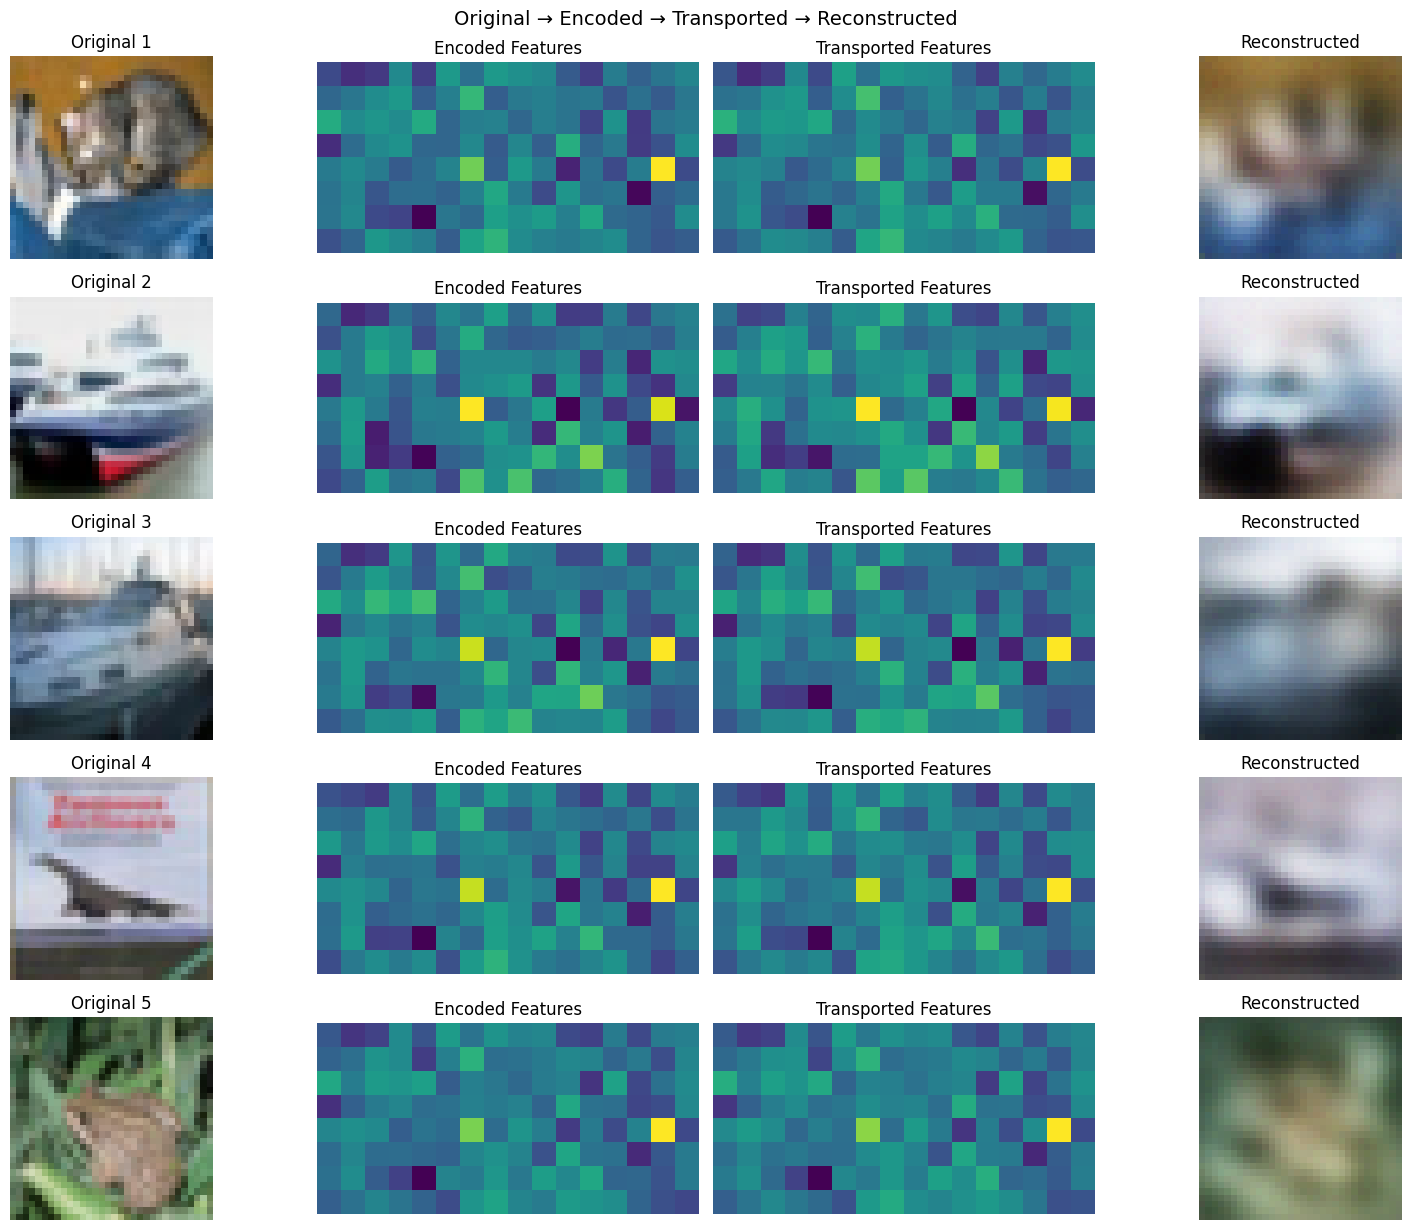

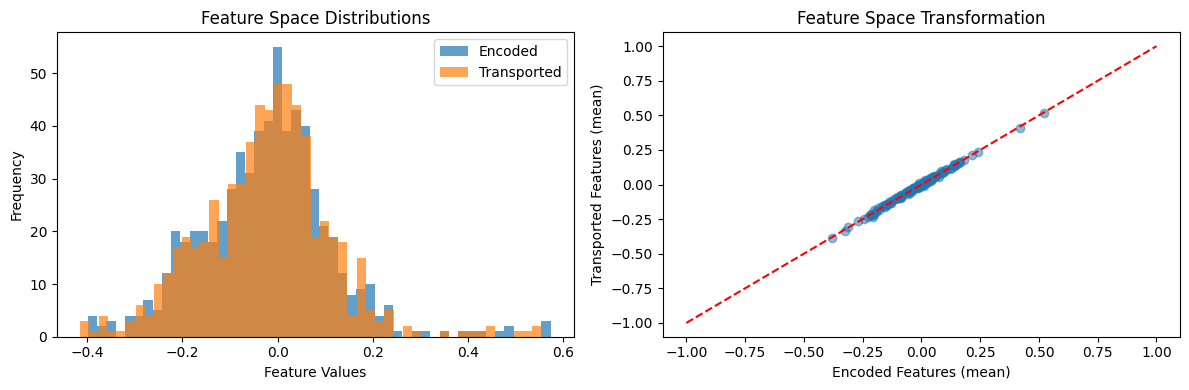

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Step 1: Load and Preprocess the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the Neural OT Model with improved architecture
class NeuralOT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralOT, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, y):
        x_mapped = self.fc(x)
        loss = torch.mean((x_mapped - y) ** 2)
        return loss

    def transport_map(self, x):
        return self.fc(x)

# Initialize the Neural OT model
input_dim = 128
hidden_dim = 256  # Increased hidden dimension
neural_ot_model = NeuralOT(input_dim, hidden_dim)

# Step 3: Define an Improved Diffusion Model
class ImprovedDiffusionModel(nn.Module):
    def __init__(self):
        super(ImprovedDiffusionModel, self).__init__()
        # Use ResNet18 as encoder but modify it for CIFAR-10
        self.encoder = resnet18(pretrained=False)
        # Modify first conv layer for CIFAR-10
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()  # Remove maxpool as CIFAR-10 is small
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128)
        
        # Improved decoder with transposed convolutions
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 4096),  # 4 x 4 x 256
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # 32 x 32
            nn.Tanh()
        )

    def forward(self, x, t=None):  # t is optional for compatibility
        x = x.view(-1, 3, 32, 32)
        encoded = self.encoder(x)
        transported = neural_ot_model.transport_map(encoded)
        decoded = self.decoder(transported)
        return decoded

# Initialize the Diffusion model
diffusion_model = ImprovedDiffusionModel()

# Step 4: Training Loop with improved loss function
def train_models(diffusion_model, neural_ot_model, train_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    diffusion_model = diffusion_model.to(device)
    neural_ot_model = neural_ot_model.to(device)
    
    optimizer = optim.Adam(list(neural_ot_model.parameters()) + 
                          list(diffusion_model.parameters()), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    reconstruction_criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        diffusion_model.train()
        neural_ot_model.train()
        total_loss = 0
        
        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            
            # Get encodings
            encoded = diffusion_model.encoder(images)
            
            # Calculate OT loss
            ot_loss = neural_ot_model(encoded, encoded)
            
            # Calculate reconstruction loss
            reconstructed = diffusion_model(images)
            recon_loss = reconstruction_criterion(reconstructed, images)
            
            # Combined loss
            loss = ot_loss + recon_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.6f}')
        
        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}')
        
    return diffusion_model, neural_ot_model

# Step 5: Enhanced visualization function with intermediates
def visualize_results(model, ot_model, dataloader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    ot_model.eval()
    
    with torch.no_grad():
        images, _ = next(iter(dataloader))
        images = images[:num_samples].to(device)
        
        # Get encoded features
        encoded = model.encoder(images)
        
        # Get transported features
        transported = ot_model.transport_map(encoded)
        
        # Get reconstructions
        reconstructed = model.decoder(transported)
        
        # Convert tensors to numpy arrays
        original_images = images.cpu().numpy()
        reconstructed_images = reconstructed.cpu().numpy()
        encoded_features = encoded.cpu().numpy()
        transported_features = transported.cpu().numpy()
        
        # Create visualization with intermediates
        fig, axes = plt.subplots(num_samples, 4, figsize=(16, 2.5*num_samples))
        fig.suptitle('Original → Encoded → Transported → Reconstructed', fontsize=14)
        
        for i in range(num_samples):
            # Original image
            orig_img = np.transpose(original_images[i], (1, 2, 0))
            orig_img = (orig_img * 0.5 + 0.5).clip(0, 1)
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f'Original {i+1}')
            axes[i, 0].axis('off')
            
            # Encoded features
            encoded_img = encoded_features[i].reshape(8, 16)  # Reshape for visualization
            axes[i, 1].imshow(encoded_img, cmap='viridis')
            axes[i, 1].set_title('Encoded Features')
            axes[i, 1].axis('off')
            
            # Transported features
            transported_img = transported_features[i].reshape(8, 16)  # Reshape for visualization
            axes[i, 2].imshow(transported_img, cmap='viridis')
            axes[i, 2].set_title('Transported Features')
            axes[i, 2].axis('off')
            
            # Reconstructed image
            recon_img = np.transpose(reconstructed_images[i], (1, 2, 0))
            recon_img = (recon_img * 0.5 + 0.5).clip(0, 1)
            axes[i, 3].imshow(recon_img)
            axes[i, 3].set_title('Reconstructed')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Additional visualization of feature space distributions
        plt.figure(figsize=(12, 4))
        
        plt.subplot(121)
        plt.hist(encoded_features.flatten(), bins=50, alpha=0.7, label='Encoded')
        plt.hist(transported_features.flatten(), bins=50, alpha=0.7, label='Transported')
        plt.title('Feature Space Distributions')
        plt.xlabel('Feature Values')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(122)
        plt.scatter(encoded_features.mean(0), transported_features.mean(0), alpha=0.5)
        plt.plot([-1, 1], [-1, 1], 'r--')  # Identity line
        plt.title('Feature Space Transformation')
        plt.xlabel('Encoded Features (mean)')
        plt.ylabel('Transported Features (mean)')
        
        plt.tight_layout()
        plt.show()

# Train the models
diffusion_model, neural_ot_model = train_models(diffusion_model, neural_ot_model, train_loader)

# Visualize results
visualize_results(diffusion_model, neural_ot_model, test_loader)